### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{5}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

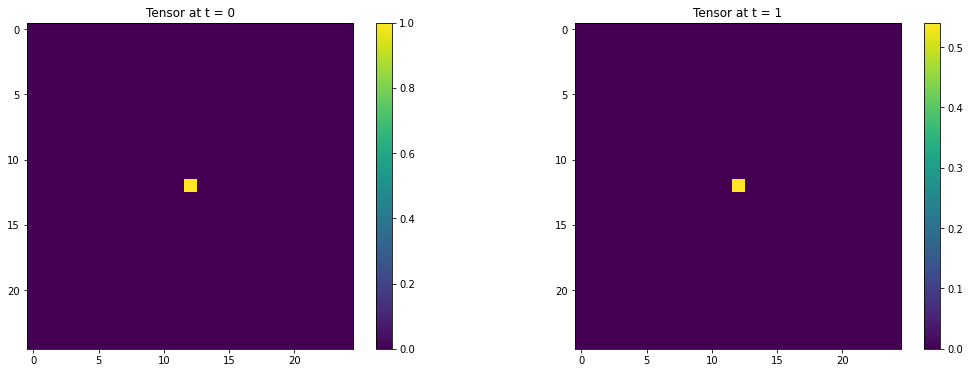

In [6]:
# Specify the size of the tensor
xysize = 25

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

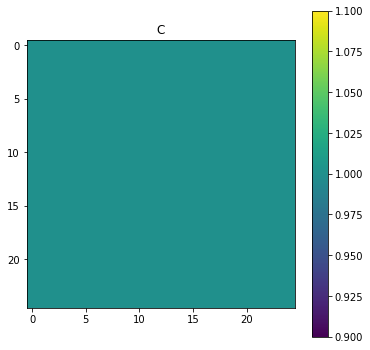

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [7]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float().requires_grad_()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

c = c.to(device)
print(c)

#### Sigma2

In [8]:
l = xysize/10

In [9]:
value_origin_point = - 9 * (4-0)
k = 400

In [10]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [11]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

0.125


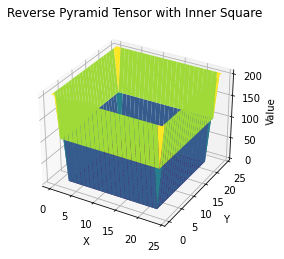

In [12]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

sigma2 = torch.from_numpy(sigma2).to(device)

tensor([[204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000],
        [204.8000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

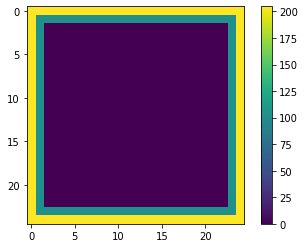

In [13]:
print(sigma2)
plt.imshow(sigma2.detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [14]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

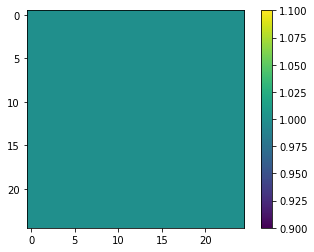

In [15]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### one time step - skipping layers

In [144]:
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv):
        output_list = [status_tn]
        # output_list = []

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [105]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [106]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

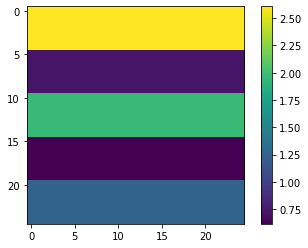

In [107]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
    ones[i*5:(i+1)*5] = 1
    c += ones * vec[i]


plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

### Data assimilation one timestep - skipping layers

#### Generate Obs

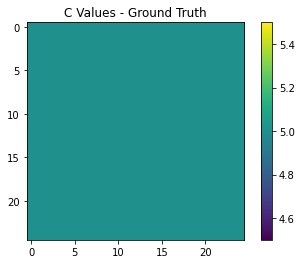

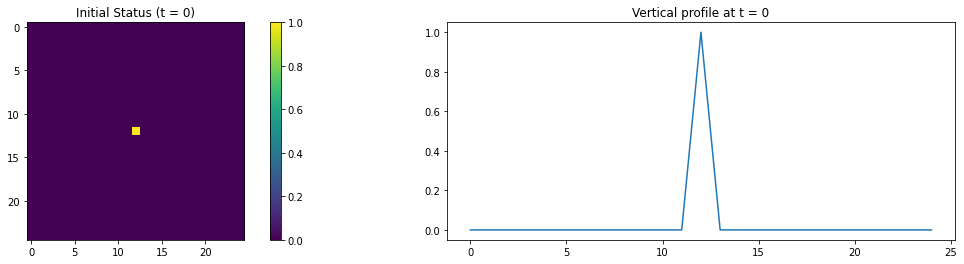

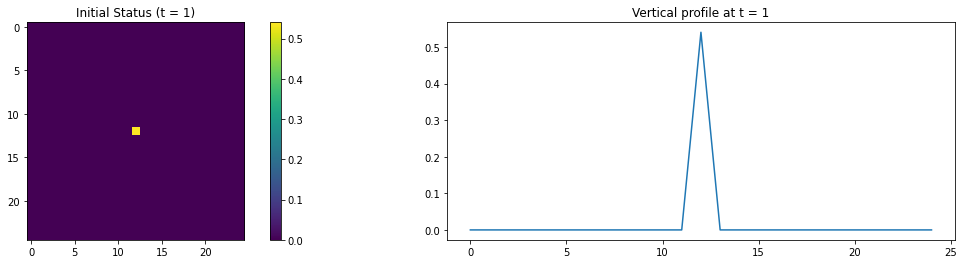

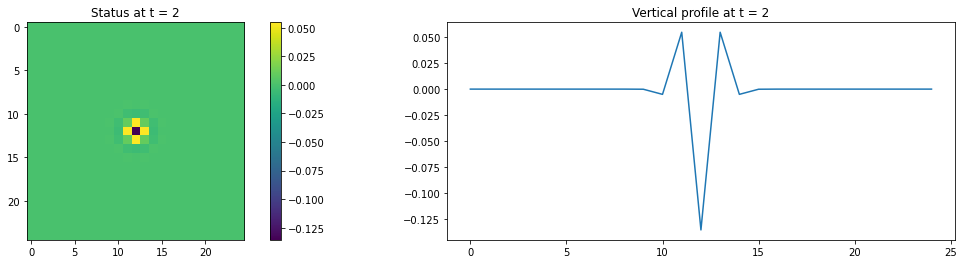

torch.Size([1, 5, 25, 25])


In [161]:
# Specify the size of the tensor
xysize = 25

timesteps = 3

# C values
C_values_list = [5, 5, 5, 5, 5]
# C_values_list = [1, 1, 1, 1, 1]
c_tensor = torch.tensor(C_values_list, dtype=torch.float32, device=device, requires_grad=True)

nlayers = c_tensor.size(0)

# Plot C
c = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)

for i in range(nlayers):
    ones = torch.zeros((xysize, xysize), device=device, dtype=torch.float32)
    ones[i*int(xysize/nlayers):(i+1)*int(xysize/nlayers)] = 1
    c += ones * c_tensor[i]

plt.imshow(c.cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

for i in range(timesteps):
    if (i) % 5 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_obs.shape)

In [162]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([5, 25, 25])


#### Bigger model result

In [163]:
mse_loss = nn.MSELoss()


### faster version


# C guess
C_guess_value = 3.0
c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1



# Use Adam optimizer
c_values = [c_forward1.tolist()]

losses = []
epochs = 1

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

for n in range(epochs):
    print(c_forward1.grad)
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    # optimizer.zero_grad()
    output_tensor_forward1 = mymodel_multi(status_t1_tensor, status_t0_tensor, c_forward1, sigma2, nsteps = timesteps)
    Status_List_stacked_forward1 = output_tensor_forward1.squeeze(0)

    # consider the whole domain to calculate loss
    loss = mse_loss(Status_List_stacked_forward1, Obs_sensor_3d_array)
    print(loss.item())

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    print(c_forward1.grad)

None
epochs: 0
9.689938451629132e-06
tensor([ 3.7291e-18, -2.4416e-08, -9.3927e-06, -2.4416e-08,  3.7291e-18],
       device='cuda:0')


#### One time forward stepping

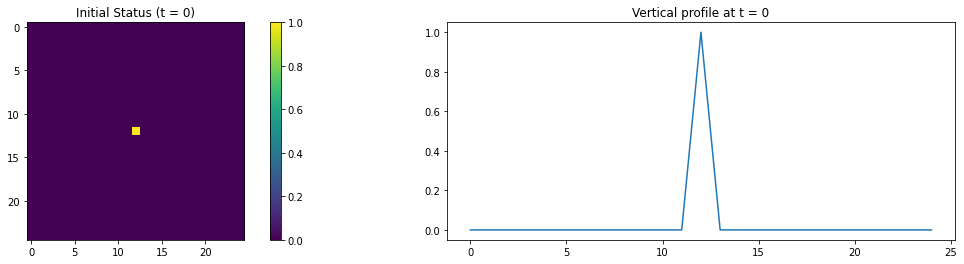

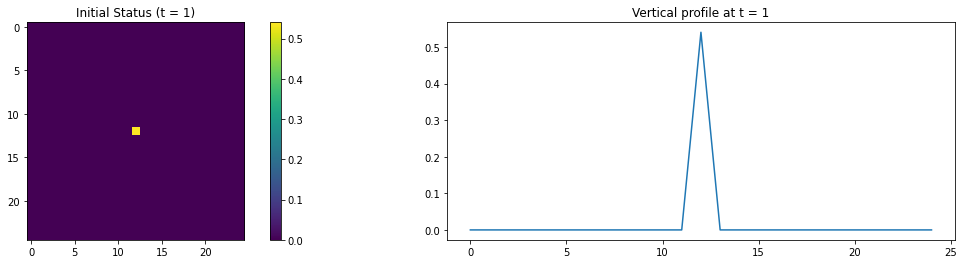

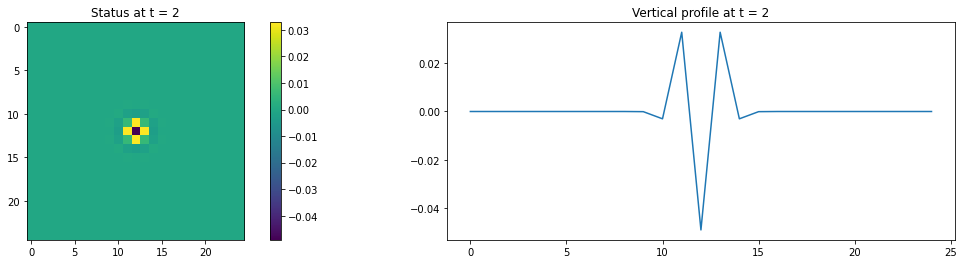

In [164]:
# C guess
C_guess_value = 3.0
c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)


mymodel_onestepSkip = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

Status_List_onestep = []
Status_List_onestep.append(status_t0.view(1, 1, xysize, xysize).to(device))
Status_List_onestep.append(status_t1.view(1, 1, xysize, xysize).to(device))
status_t0 = status_t0.to(device)
status_t1 = status_t1.to(device)

# vmin, vmax = -1, 1  # Set vmin and vmax

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

status_tn_1 = status_t0.view(1, 1, xysize, xysize)
status_tn = status_t1.view(1, 1, xysize, xysize)

for i in range(timesteps):
    status_tn_1 = status_tn_1.to(device)
    status_tn = status_tn.to(device)

    # Perform a forward pass
    output = mymodel_onestepSkip(status_tn, status_tn_1, c_forward1, sigma2)
    status_tn1 = output[:, -1, :, :].view(1, 1, xysize, xysize)
    
    # plt.figure(figsize=(10, 4))
    # plt.imshow(status_tn1.cpu().detach().numpy()[0][0], vmin=vmin, vmax=vmax, cmap='viridis')
    # # plt.imshow(status_tn1.cpu().detach().numpy()[0][0], cmap='viridis')
    # plt.colorbar()
    # plt.title(f"Status at t = {i+1}")
    status_detached = status_tn1.cpu().detach().numpy()[0][0]
    Status_List_onestep.append(status_tn1)

    status_tn_1 = status_tn
    status_tn = status_tn1

    # Plot the result for every 100 timesteps
    # Plot the result for every 100 timesteps
    if (i) % 10 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(status_tn1.cpu().detach().numpy()[0][0], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = status_tn1.cpu().detach().numpy()[0][0][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()
    
    # return Status_List_onestep


# Status_List_onestep = plot_diffusion(status_t0, status_t1, 200)

In [165]:
Status_List_onestep_stacked = torch.cat(Status_List_onestep, dim=1)
print(Status_List_onestep_stacked.shape)

torch.Size([1, 5, 25, 25])


#### Create data mismatch between two forward simulations

In [166]:
print(Obs_sensor_3d_array.shape)

torch.Size([5, 25, 25])


In [167]:
Status_List_stacked_forward1 = Status_List_onestep_stacked.squeeze(0)

# consider the whole domain to calculate loss
loss = mse_loss(Status_List_stacked_forward1[-80:], Obs_sensor_3d_array[-80:])
print(loss.item())
print(len(Status_List_stacked_forward1[-80:]))

9.689938451629132e-06
5


In [168]:
# consider the whole domain to calculate loss
loss = mse_loss(Status_List_stacked_forward1[-81:], Obs_sensor_3d_array[-81:])
print(loss.item())
print(len(Status_List_stacked_forward1[-82:]))

9.689938451629132e-06
5


In [169]:
# consider the whole domain to calculate loss
loss = mse_loss(Status_List_stacked_forward1[:], Obs_sensor_3d_array[:])
print(loss.item())
print(len(Status_List_stacked_forward1[:]))

9.689938451629132e-06
5


#### Backpropogate one step

In [196]:
mse_loss = nn.MSELoss()


### faster version


# C guess
C_guess_value = 3.0
c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1



# Use Adam optimizer
c_values = [c_forward1.tolist()]

losses = []
epochs = 1

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define smaller models
mymodel1 = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)
mymodel2 = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)
mymodel3 = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

output_list = [status_t0_tensor, status_t1_tensor]

for n in range(epochs):
    # Forward pass through smaller models
    print(status_t1_tensor.shape)
    print(status_t0_tensor.shape)
    output1 = mymodel1(status_t1_tensor, status_t0_tensor, c_forward1, sigma2)
    print(output1.shape)
    print(output1[:,1:, :, :].shape)
    print(output1[:,0:1, :, :].shape)
    output2 = mymodel2(output1[:,1:, :, :], output1[:,0:1, :, :], c_forward1, sigma2)  # Use the output of mymodel1 as the input to mymodel2
    print(output2.shape)
    output_tensor_forward1 = mymodel3(output2[:,1:, :, :], output2[:,0:1, :, :], c_forward1, sigma2)  # Use the output of mymodel2 as the input to mymodel3

    output_list.append(output1[:,1:, :, :])
    output_list.append(output2[:,1:, :, :])
    output_list.append(output_tensor_forward1[:,1:, :, :])

# Concatenate the output list along the time dimension
output_tensor = torch.cat(output_list, dim=1).squeeze(0)
print(output_tensor.shape)

# Compute the loss
loss = mse_loss(output_tensor, Obs_sensor_3d_array)

# Backward pass to calculate gradients
loss.backward(retain_graph=True)

losses.append(loss.item())

print(c_forward1.grad)


torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 2, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 2, 25, 25])
torch.Size([5, 25, 25])
tensor([ 3.7291e-18, -2.4416e-08, -9.3927e-06, -2.4416e-08,  3.7291e-18],
       device='cuda:0')


In [ ]:
None
epochs: 0
9.689938451629132e-06
tensor([ 3.7291e-18, -2.4416e-08, -9.3927e-06, -2.4416e-08,  3.7291e-18],
       device='cuda:0')

In [155]:
print(len(Obs_sensor_3d_array))

82


In [160]:
# Define the number of steps
num_steps = 80

# Initialize the loss function
mse_loss = nn.MSELoss()

# Initialize the model
mymodel = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

overall_mismatch = 0

# Initialize c_np
C_guess_value = 3.0
c = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

# Loop over the number of steps
for i in range(num_steps):
    # Zero the gradients
    c.grad = None

    # Get the status at time n and n-1
    status_tn = Status_List_onestep[-(i+2)].clone().requires_grad_()
    status_tn_1 = Status_List_onestep[-(i+3)].clone().requires_grad_()

    # Forward pass
    output_statuses = mymodel(status_tn, status_tn_1, c, sigma2).squeeze(0)
    # status_tn1 = output_statuses[-2:-1]
    status_tn1 = output_statuses
    # print(status_tn1.shape)

    # Compute the loss
    # dF = mse_loss(status_tn1, Obs_sensor_3d_array[-(i+1)].to(device))
    # print(output_statuses.shape)
    # print(Status_List_stacked_obs[-(i+2):-(i)].shape)
    dF = mse_loss(output_statuses, Status_List_stacked_obs[-(i+3):-(i+1)].to(device))

    overall_mismatch = overall_mismatch + dF

    # Sum the gradients
    grad_status_tn_scaler = torch.sum(status_tn.grad) if status_tn.grad is not None else 0
    grad_status_tn_1_scaler = torch.sum(status_tn_1.grad) if status_tn_1.grad is not None else 0
    grad_c_scaler = torch.sum(c.grad) if c.grad is not None else 0

    loss = dF + grad_status_tn_scaler + grad_status_tn_1_scaler +  grad_c_scaler if i > 0 else dF
    # loss = dF + grad_c_scaler if i > 0 else dF

    # Backward pass
    loss.backward(retain_graph=True)

print(c.grad)

print(overall_mismatch)
print(-(i+2))

tensor([0.0000e+00, 1.2377e-07, 4.2925e-05, 1.2377e-07, 0.0000e+00],
       device='cuda:0')
tensor(0.2700, device='cuda:0', grad_fn=<AddBackward0>)
-81


In [ ]:
tensor([-4.0257e-05, -1.6394e-04, -8.4142e-04, -1.6394e-04, -4.0257e-05],
       device='cuda:0')

In [129]:
# Define the number of steps
num_steps = 80

# Initialize the loss function
mse_loss = nn.MSELoss()

# Initialize the model
mymodel = AI4WaveNeuralNetwork_One_Skipping(xysize, filter_weight)

# Initialize c_np
C_guess_value = 3.0
c = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

overall_mismatch = 0

# Loop over the number of steps
for i in range(num_steps):
    # Zero the gradients
    if c.grad is not None:
        c.grad.zero_()

    # Get the status at time n and n-1
    status_tn = Status_List_onestep[-(i+2)].clone().requires_grad_()
    status_tn_1 = Status_List_onestep[-(i+3)].clone().requires_grad_()

    # Forward pass
    output_statuses = mymodel(status_tn, status_tn_1, c, sigma2).squeeze(0)
    status_tn1 = output_statuses

    # Compute the loss
    loss = mse_loss(status_tn1, Obs_sensor_3d_array[-(i+1)].to(device))

    overall_mismatch = overall_mismatch + loss

    # Backward pass
    loss.backward(retain_graph=True)

    # Sum the gradients
    grad_status_tn_scaler = torch.sum(status_tn.grad) if status_tn.grad is not None else 0
    grad_status_tn_1_scaler = torch.sum(status_tn_1.grad) if status_tn_1.grad is not None else 0
    grad_c_scaler = torch.sum(c.grad) if c.grad is not None else 0

print(c.grad)

print(overall_mismatch)

/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([25, 25])) that is different to the input size (torch.Size([1, 25, 25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dg321/anaconda3/envs/icdss/lib/python3.8/site-packages/torch/_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:475.)
  return self._grad


tensor([ 0.0000e+00, -3.6464e-08, -1.5100e-05, -3.6464e-08,  0.0000e+00],
       device='cuda:0')
tensor(0.2918, device='cuda:0', grad_fn=<AddBackward0>)
